#   Data Science 
## Simplified Approximation of Extraordinary Losses on a Lending Portfolio

## <font color='green'>Deep Neural Network Model</font>

### Project Description
Financial Institutions are expected to hold capital reserves sufficient to withstand unlikely but potentially catastrophic loss events. The reserve for a risky loan is higher than the reserve for a safer loan, and this difference should be reflected in the interest rate offered by the lender. However, the loss calculations are too cumbersome to be performed every time someone seeks a loan. The goal of this project is to approximate those loss calculations, with an alternative model that could be fast enough to use during lending, but sufficiently accurate to avoid under- or over- pricing loans.

### Expected outcome
The expected outcome would be a Python function or method that predicts the outcome of the “true” loss calculation process for an arbitrary loan. This function or method will be applied to a TEST dataset whose “true” loss reserve amounts have been withheld, and its performance will be assessed against those “true” amounts.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns; sns.set(style="ticks", color_codes=True)

## Load Data from csv

In [3]:
df = pd.read_csv(r'C:\FAIZA\DATA SCIENCE\Assignment\Development Dataset - With Actuals.csv')
df.head()

,Instrument,Instrument Type,Instrument Subtype,Counterparty Alias,MTM Exposure,Book Exposure,1-Year Likelihood,Severity Used,Industry Alias,Commitment,Country of Incorporation,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation
0,86540,Loan,Term Loan Amortizing,C23099,224013.330,224013.33,0.160200,0.057,IND1,224013.33,CAN,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976
1,86099,Loan,Revolver,C43055,135000.000,135000.00,0.036900,0.817,IND1,135000.00,CAN,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077
2,5738,Loan,Term Loan Amortizing,C11421,36190.953,36190.95,0.036900,0.019,IND2,36190.95,CAN,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469
3,165996,Loan,Term Loan Amortizing,C44251,84600.000,84600.00,0.006525,0.019,IND1,84600.00,CAN,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077
4,118169,Loan,Term Loan Amortizing,C53713,37508.787,37508.78,0.020475,0.247,IND1,37508.78,CAN,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495


In [4]:
#df.describe()
df.describe().loc[['min','max', 'mean']].transpose()

,min,max,mean
Instrument,1.000000,1.665320e+05,83299.863382
MTM Exposure,0.063000,2.475000e+08,275199.419719
Book Exposure,0.060000,2.475000e+08,266103.066846
1-Year Likelihood,0.000225,1.000000e+00,0.061460
Severity Used,0.009500,8.170000e-01,0.081395
Commitment,0.060000,2.475000e+08,275633.375810
Time to Maturity,0.002738,7.942779e+01,7.166776
Capital - EL Tail Risk Contribution (Capped),-16.630000,3.345287e+07,16286.966120
Capitalization Rate - EL Tail Risk Contribution,-0.000123,2.834707e+00,0.056623
Asset Recovery Correlation,0.192410,5.924700e-01,0.275837


## Building Model on Initial (untreated) Dataset
#### This is just to test models prior to data transformation.

In [5]:
dms = pd.get_dummies(df[['Instrument Type', 'Instrument Subtype']])

y1 = df['Capital - EL Tail Risk Contribution (Capped)']

features_to_drop = ['Instrument','Instrument Type', 'Instrument Subtype', 'Counterparty Alias', 
                    'Book Exposure', 'Industry Alias','Commitment', 'Country of Incorporation', 
                    'Maturity Date', 'Capital - EL Tail Risk Contribution (Capped)', 
                    'Capitalization Rate - EL Tail Risk Contribution']

X_ = df.drop(features_to_drop, axis=1).astype('float64')

X1 = pd.concat([X_, dms[['Instrument Type_Loan', 'Instrument Subtype_Revolver']]], axis=1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 
                                                    y1, 
                                                    test_size=0.25, 
                                                    random_state=42)
#X_train

### Lasso Regression Model

In [6]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X1_train, y1_train)
print('---  R-squared score for LASSO model on Training set: %.3f ' % lasso_model.score(X1_train, y1_train))

pred_lasso = lasso_model.predict(X1_test)

print('--- MAE for LASSO Model on testing set: %.2f' % (mean_absolute_error(y1_test, pred_lasso)))
print('--- R-squared score for LASSO Model on testing set: %.3f' % r2_score(y1_test,pred_lasso))

---  R-squared score for LASSO model on Training set: 0.366 
--- MAE for LASSO Model on testing set: 16571.62
--- R-squared score for LASSO Model on testing set: 0.518


### Ridge Regression Model

In [7]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X1_train, y1_train)
print('--- R-squared score for  RIDGE model on Training set: %.3f ' % ridge_model.score(X1_train, y1_train))

pred_ridge = ridge_model.predict(X1_test)

print('--- MAE for RIDGE Model on testing set: %.2f' % (mean_absolute_error(y1_test, pred_ridge)))
print('--- R-squared for RIDGE Model on testing set: %.3f' % r2_score(y1_test,pred_ridge))

--- R-squared score for  RIDGE model on Training set: 0.366 
--- MAE for RIDGE Model on testing set: 16560.48
--- R-squared for RIDGE Model on testing set: 0.519


# Data Pre-Processing

## Feature Engineering (Data Transformation)

### Dimensionality Reduction
Here, we remove redundant or excess data from the large dataset to make analysis easier.

#### Let’s look at the unique values in the ‘Country of Incorporation’:

In [8]:
#df1['Counterparty Alias'].count()
df['Country of Incorporation'].unique()

array(['CAN'], dtype=object)

The entire column contains only one value so it can be dropped:

In [9]:
df1 = df.copy()
df1 = df1.drop(['Country of Incorporation'], axis=1)

### One Hot Encoding

Some of our data are categorical e.g.they have discrete values. We will use the 1-hot encoding process to transform the values of such columns into binary data (0,1).A column is added for every categorical data, with values 0 or 1 depending on the data.

Then, we drop the categorical columns and other irrelevant columns, and combine the new dataframe and dummies.

In [10]:
df_dummies = pd.get_dummies(df1[['Instrument Type', 'Instrument Subtype']])
df_dummies

,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,Instrument Subtype_Term Loan Amortizing
0,0,1,0,1
1,0,1,1,0
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1
...,...,...,...,...
151527,0,1,0,1
151528,0,1,1,0
151529,0,1,0,1
151530,0,1,0,1


In [11]:
df2 = df1.drop(['Instrument Type', 'Instrument Subtype'], axis = 1)
df_actuals = pd.concat([df2, df_dummies], axis=1)
df_actuals

,Instrument,Counterparty Alias,MTM Exposure,Book Exposure,1-Year Likelihood,Severity Used,Industry Alias,Commitment,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,Instrument Subtype_Term Loan Amortizing
0,86540,C23099,224013.330,224013.33,0.160200,0.0570,IND1,224013.33,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976,0,1,0,1
1,86099,C43055,135000.000,135000.00,0.036900,0.8170,IND1,135000.00,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077,0,1,1,0
2,5738,C11421,36190.953,36190.95,0.036900,0.0190,IND2,36190.95,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469,0,1,0,1
3,165996,C44251,84600.000,84600.00,0.006525,0.0190,IND1,84600.00,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077,0,1,0,1
4,118169,C53713,37508.787,37508.78,0.020475,0.2470,IND1,37508.78,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151527,126599,C9779,260814.096,260814.09,0.112725,0.0095,IND1,260814.09,05/01/2040,18.751540,20564.36,0.078847,0.26706,0.34109,0.1347,0,1,0,1
151528,165919,C23546,45000.000,45000.00,0.006525,0.8170,IND1,45000.00,05/01/2023,1.749487,4657.72,0.103505,0.26706,0.34109,0.1077,0,1,1,0
151529,18381,C24812,182174.661,182174.66,0.020700,0.0095,IND1,182174.66,05/01/2030,8.750171,3428.36,0.018819,0.26706,0.34109,0.1235,0,1,0,1
151530,116229,C34960,1179864.819,1179864.81,0.014400,0.0095,IND1,1179864.81,10/25/2039,18.234086,26063.25,0.022090,0.26706,0.34109,0.0769,0,1,0,1


### Another Column that requires transformation is the 'Industry Alias' which contains 40 unique values. 
#### Due to higher order values, on-hot encoding will not work well here. Instead, we will substring the value to drop the "IND" and keep the numerical values. 
PS: These are not ordinal values so no natural ordering between the values.

In [12]:
#label = LabelEncoder()
#dummy_encoded_df['Industry Alias'] = label.fit_transform(dummy_encoded_df['Industry Alias'])

In [13]:
#unique values in column before transformation...
df_actuals['Industry Alias'].unique()

array(['IND1', 'IND2', 'IND3', 'IND23', 'IND8', 'IND5', 'IND30', 'IND6',
       'IND9', 'IND7', 'IND4', 'IND21', 'IND19', 'IND10', 'IND29',
       'IND25', 'IND11', 'IND12', 'IND18', 'IND13', 'IND26', 'IND14',
       'IND40', 'IND32', 'IND15', 'IND28', 'IND22', 'IND27', 'IND17',
       'IND39', 'IND34', 'IND35', 'IND16', 'IND36', 'IND24', 'IND37',
       'IND20', 'IND38', 'IND33', 'IND31'], dtype=object)

In [14]:
#replace column data with substring containing only the numerical values...
temp = df_actuals['Industry Alias'].str[3:5]
df_actuals['Industry Alias'] = temp.astype('float64')
df_actuals['Industry Alias'].unique()

array([ 1.,  2.,  3., 23.,  8.,  5., 30.,  6.,  9.,  7.,  4., 21., 19.,
       10., 29., 25., 11., 12., 18., 13., 26., 14., 40., 32., 15., 28.,
       22., 27., 17., 39., 34., 35., 16., 36., 24., 37., 20., 38., 33.,
       31.])

### Check for Null values in Dataframe

In [15]:
df_actuals.isnull().sum()

Instrument                                         0
Counterparty Alias                                 0
MTM Exposure                                       0
Book Exposure                                      0
1-Year Likelihood                                  0
Severity Used                                      0
Industry Alias                                     0
Commitment                                         0
Maturity Date                                      0
Time to Maturity                                   0
Capital - EL Tail Risk Contribution (Capped)       0
Capitalization Rate - EL Tail Risk Contribution    0
Asset Recovery Correlation                         0
Recovery R-Squared for Simulation                  0
Asset R-Squared for Simulation                     0
Instrument Type_Bond                               0
Instrument Type_Loan                               0
Instrument Subtype_Revolver                        0
Instrument Subtype_Term Loan Amortizing       

#### After the transformation, there are no Null values in our dataset!

## Handling Outliers

## Data Visualization
After cleaning and transforming the data, we will analyze it using different visualization techniques and graphs.

### Correlation Evaluation Metrics
#### Finding Correlation between variables

In [19]:
df_actuals.corr()

,Instrument,MTM Exposure,Book Exposure,1-Year Likelihood,Severity Used,Industry Alias,Commitment,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,Instrument Subtype_Term Loan Amortizing
Instrument,1.000000,0.031331,0.032678,-0.037631,0.133743,0.048214,0.031239,0.134354,0.030505,0.026900,-0.076329,0.012388,-0.036613,0.025155,-0.025155,-0.103648,0.102833
MTM Exposure,0.031331,1.000000,0.994324,0.004468,-0.015614,0.224763,0.999870,0.098715,0.635304,0.003419,0.109655,0.252960,0.092684,0.488740,-0.488740,-0.014773,-0.000672
Book Exposure,0.032678,0.994324,1.000000,0.005251,-0.014893,0.225981,0.994469,0.105574,0.632474,0.006446,0.107116,0.246124,0.094338,0.500409,-0.500409,-0.024927,0.009111
1-Year Likelihood,-0.037631,0.004468,0.005251,1.000000,0.043579,0.067299,0.006425,-0.075059,0.093422,0.685772,0.008826,-0.004199,0.011279,-0.006779,0.006779,0.089920,-0.089688
Severity Used,0.133743,-0.015614,-0.014893,0.043579,1.000000,0.054424,-0.015240,-0.225860,0.035684,0.326839,-0.005895,-0.001145,-0.012093,0.024223,-0.024223,0.328026,-0.328727
Industry Alias,0.048214,0.224763,0.225981,0.067299,0.054424,1.000000,0.225012,-0.004765,0.133109,0.048133,0.090013,-0.019485,-0.125626,0.306078,-0.306078,-0.017264,0.007590
Commitment,0.031239,0.999870,0.994469,0.006425,-0.015240,0.225012,1.000000,0.098767,0.638131,0.006334,0.109698,0.252984,0.092523,0.488568,-0.488568,-0.014915,-0.000524
Time to Maturity,0.134354,0.098715,0.105574,-0.075059,-0.225860,-0.004765,0.098767,1.000000,0.061472,-0.028732,0.068657,-0.022664,-0.115136,-0.012671,0.012671,-0.504375,0.504677
Capital - EL Tail Risk Contribution (Capped),0.030505,0.635304,0.632474,0.093422,0.035684,0.133109,0.638131,0.061472,1.000000,0.115471,0.074388,0.174618,0.028822,0.153595,-0.153595,-0.010105,0.005250
Capitalization Rate - EL Tail Risk Contribution,0.026900,0.003419,0.006446,0.685772,0.326839,0.048133,0.006334,-0.028732,0.115471,1.000000,0.017761,0.005755,0.019076,-0.004541,0.004541,0.088297,-0.088137


In [20]:
#checking correlation using pair plots
#v_pairs = sns.pairplot(df_actuals, x_vars=['Book Exposure','MTM Exposure','1-Year Likelihood','Severity Used', 'Commitment',
#                                            'Time to Maturity', 'Asset Recovery Correlation','Recovery R-Squared for Simulation' ], 
#                         y_vars='Capital - EL Tail Risk Contribution (Capped)', height=7, aspect=0.7, kind='reg')

#v_pairs.fig.suptitle('Capital ($) vs. other variables', y=1.03)

Text(0.5, 1.03, 'Capital ($) vs. other variables')

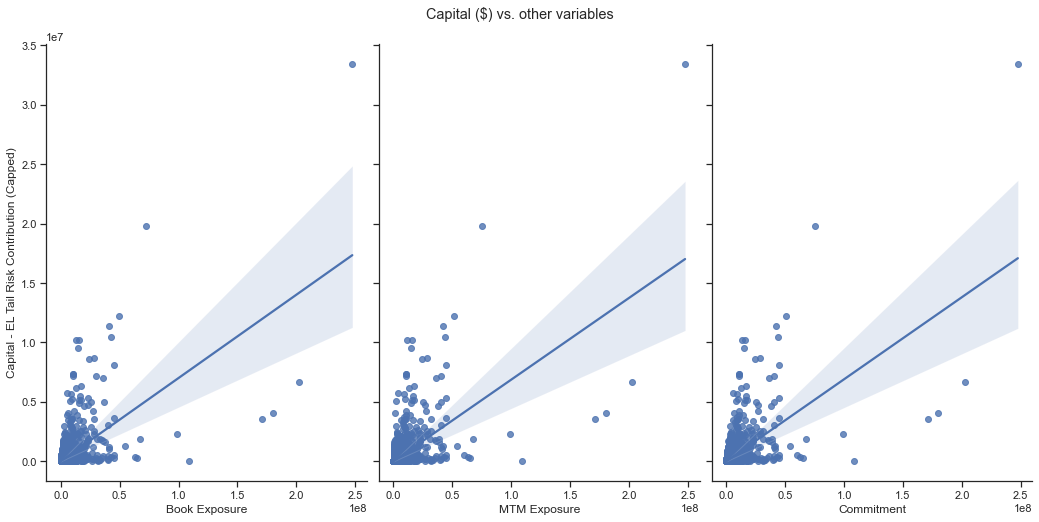

In [21]:
#checking correlation using pair plots
corr_pairs = sns.pairplot(df_actuals, x_vars=['Book Exposure','MTM Exposure','Commitment'], 
                         y_vars='Capital - EL Tail Risk Contribution (Capped)', height=7, aspect=0.7, kind='reg')

corr_pairs.fig.suptitle('Capital ($) vs. other variables', y=1.03)

#### Including all 3 variables (Commitment, MTM Exposure and Book Exposure) may not improve the prediction accuracy of our model as they are HIGLY correlatated and have a similar relationship with the dependent variable, 'Capital - EL Tail Risk Contribution (Capped)'.

<AxesSubplot:xlabel='Book Exposure', ylabel='Commitment'>

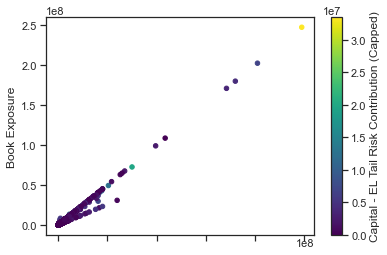

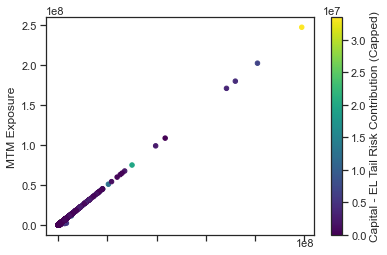

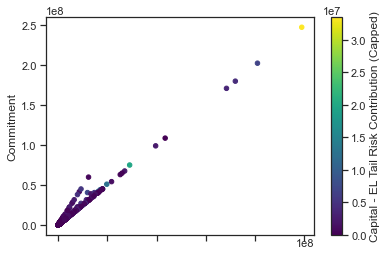

In [22]:
df_actuals.plot.scatter(x='MTM Exposure',
                      y='Book Exposure',
                      c='Capital - EL Tail Risk Contribution (Capped)',
                       colormap='viridis')
df_actuals.plot.scatter(x='Commitment',
                      y='MTM Exposure',
                      c='Capital - EL Tail Risk Contribution (Capped)',
                       colormap='viridis')

df_actuals.plot.scatter(x='Book Exposure',
                      y='Commitment',
                      c='Capital - EL Tail Risk Contribution (Capped)',
                       colormap='viridis')

array([[<AxesSubplot:title={'center':'Commitment'}>,
        <AxesSubplot:title={'center':'MTM Exposure'}>],
       [<AxesSubplot:title={'center':'Book Exposure'}>, <AxesSubplot:>]],
      dtype=object)

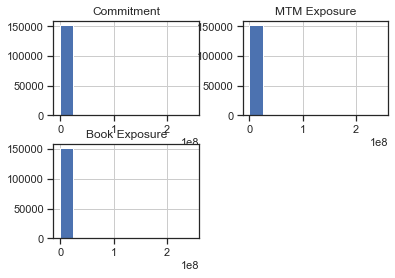

In [23]:
df_actuals[['Commitment', 'MTM Exposure', 'Book Exposure']].hist()

### Using HeatMap to check Correlation

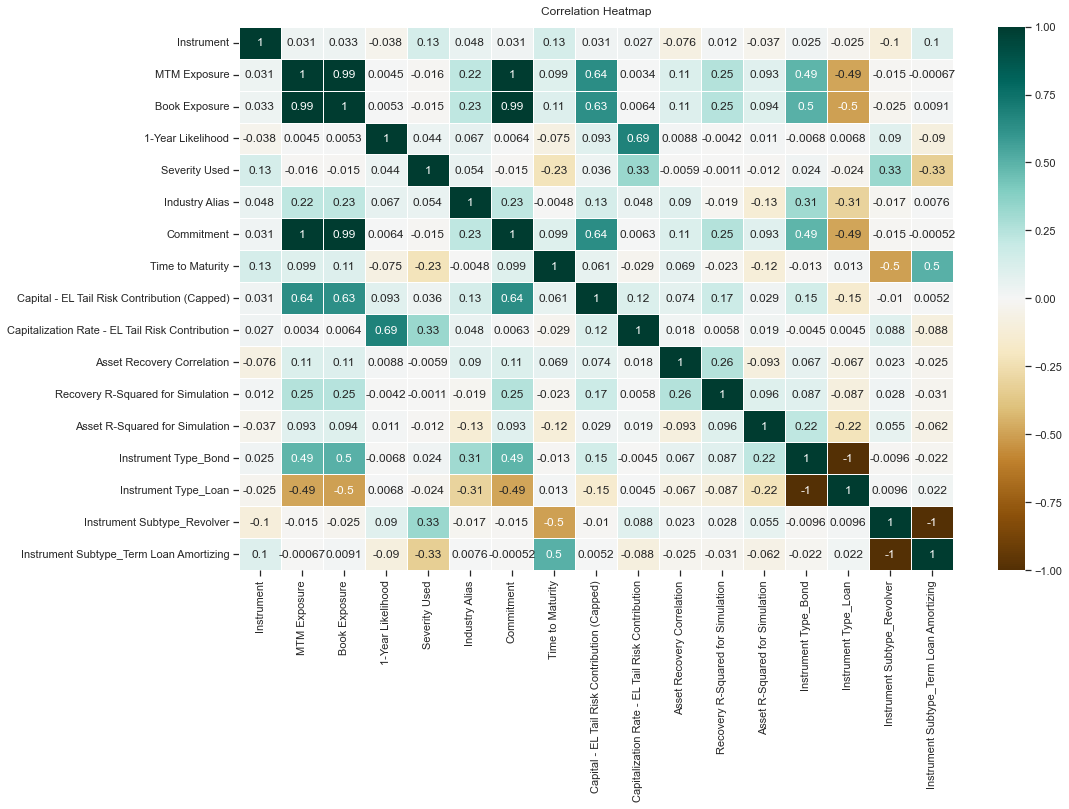

In [24]:
#data = df_actuals.drop(['Instrument'], axis=1)
#fig, ax = plt.subplots(figsize=(16,10))  
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_actuals.corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG",linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
#plt.show()

#### Checking the correlation of all features against our dependent variable ‘Capital - EL Tail Risk Contribution (Capped)’.

In [25]:
df_actuals.corr()[['Capital - EL Tail Risk Contribution (Capped)']].sort_values(by='Capital - EL Tail Risk Contribution (Capped)', ascending=False)


,Capital - EL Tail Risk Contribution (Capped)
Capital - EL Tail Risk Contribution (Capped),1.000000
Commitment,0.638131
MTM Exposure,0.635304
Book Exposure,0.632474
Recovery R-Squared for Simulation,0.174618
Instrument Type_Bond,0.153595
Industry Alias,0.133109
Capitalization Rate - EL Tail Risk Contribution,0.115471
1-Year Likelihood,0.093422
Asset Recovery Correlation,0.074388


#### Let's create a colored map that shows the strength of the correlation between every <i>possible</i> independent variable that we want to include in our model againt the dependent (target) variable.

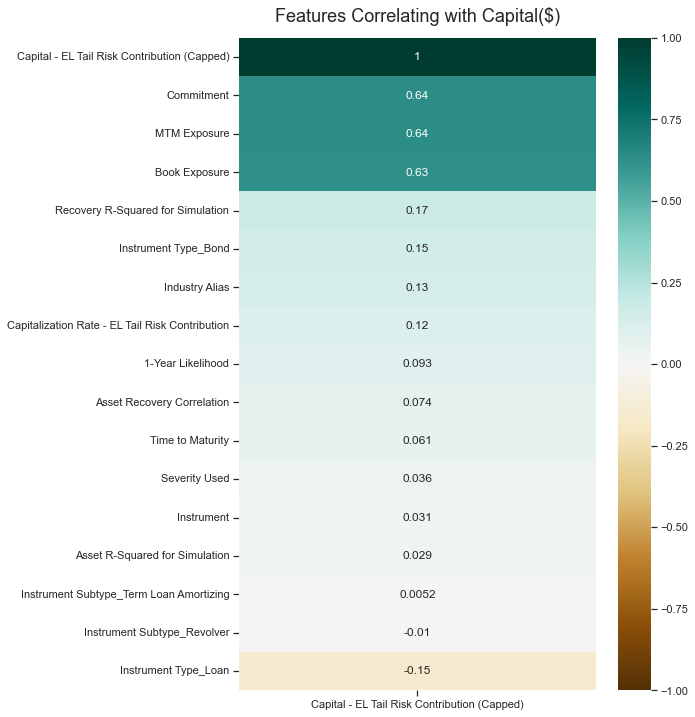

In [26]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_actuals.corr()[['Capital - EL Tail Risk Contribution (Capped)']].sort_values(by='Capital - EL Tail Risk Contribution (Capped)', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Capital($)', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmap2.png', dpi=300, bbox_inches='tight')


### Based on our understanding from the heatmap 'Commitment' (highest correlation) as a potential candidate for the independent variable for our model and re-evaluate:

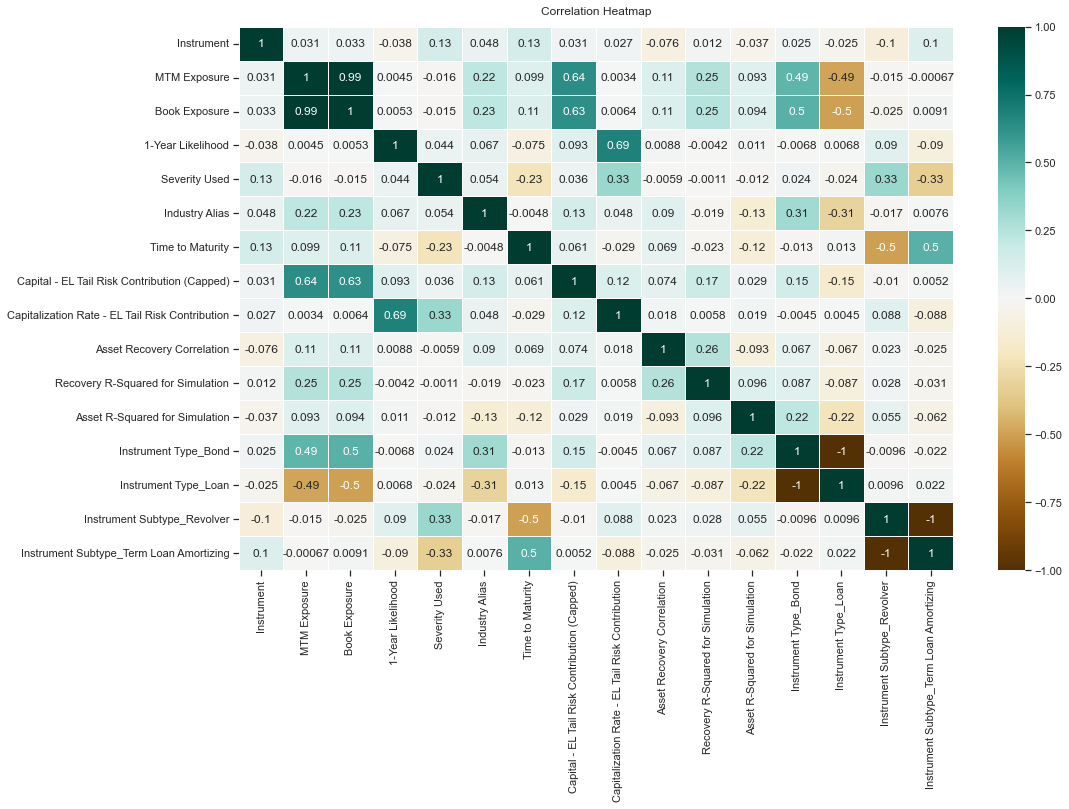

In [27]:
df_1 = df_actuals.copy()
df_1=df_1.drop(['Commitment'], axis=1)
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_1.corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG",linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### We again see from the heatmap that MTM Exposure and Book Exposure have similar correlation coefficient to our target variable.

We will drop Book Exposure and re-evaluate with the heatmap. We will also drop one from the pairs of features that are 100% negatively correlated.

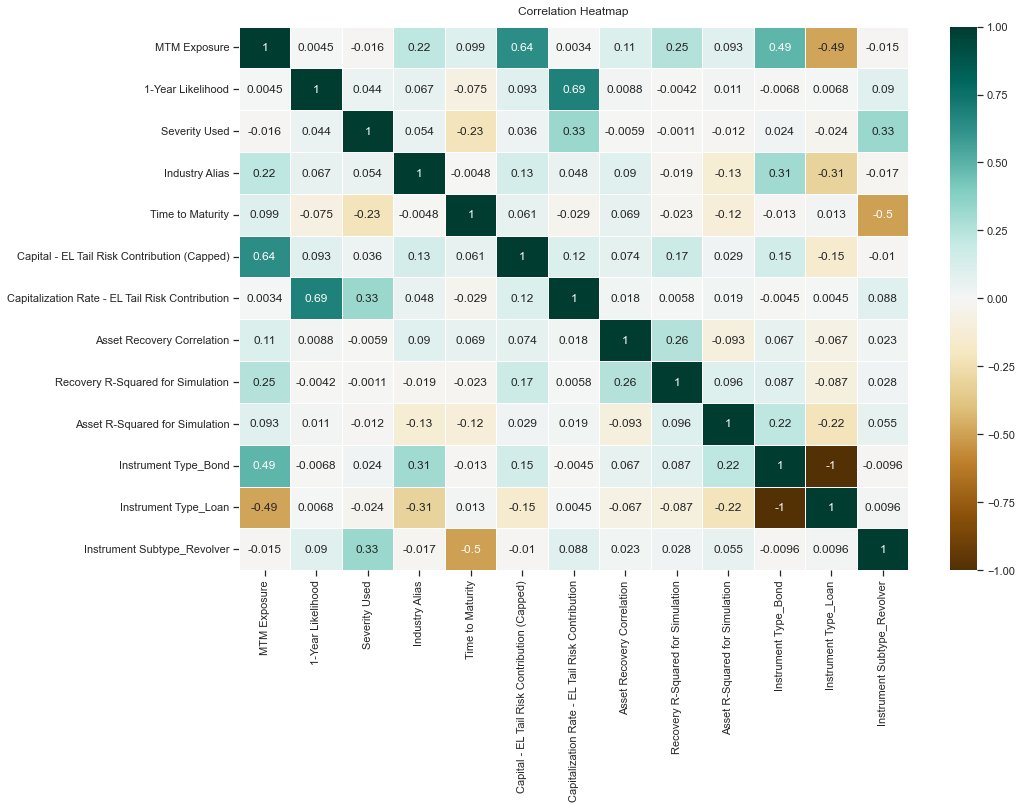

In [28]:
df_2=df_1.drop(['Instrument','Book Exposure', 'Counterparty Alias', 'Instrument Subtype_Term Loan Amortizing'], axis=1)
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(df_2.corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG",linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

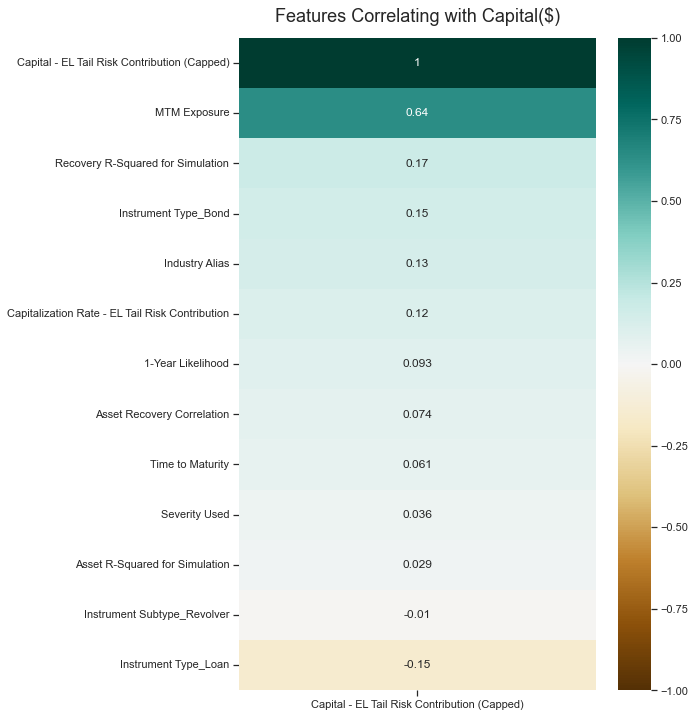

In [29]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_2.corr()[['Capital - EL Tail Risk Contribution (Capped)']].sort_values(by='Capital - EL Tail Risk Contribution (Capped)', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Capital($)', fontdict={'fontsize':18}, pad=16);
#plt.savefig('heatmap2.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.03, 'Capital ($) vs. other variables')

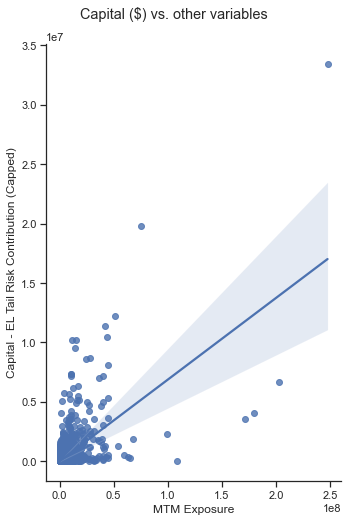

In [47]:
corr_pairs = sns.pairplot(df_actuals, x_vars=['MTM Exposure'], 
                         y_vars='Capital - EL Tail Risk Contribution (Capped)', height=7, aspect=0.7, kind='reg')

corr_pairs.fig.suptitle('Capital ($) vs. other variables', y=1.03)

In [30]:
df_dev = df_2.copy()
df_dev

,MTM Exposure,1-Year Likelihood,Severity Used,Industry Alias,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver
0,224013.330,0.160200,0.0570,1.0,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976,0,1,0
1,135000.000,0.036900,0.8170,1.0,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077,0,1,1
2,36190.953,0.036900,0.0190,2.0,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469,0,1,0
3,84600.000,0.006525,0.0190,1.0,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077,0,1,0
4,37508.787,0.020475,0.2470,1.0,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151527,260814.096,0.112725,0.0095,1.0,05/01/2040,18.751540,20564.36,0.078847,0.26706,0.34109,0.1347,0,1,0
151528,45000.000,0.006525,0.8170,1.0,05/01/2023,1.749487,4657.72,0.103505,0.26706,0.34109,0.1077,0,1,1
151529,182174.661,0.020700,0.0095,1.0,05/01/2030,8.750171,3428.36,0.018819,0.26706,0.34109,0.1235,0,1,0
151530,1179864.819,0.014400,0.0095,1.0,10/25/2039,18.234086,26063.25,0.022090,0.26706,0.34109,0.0769,0,1,0


## Rescaling the data

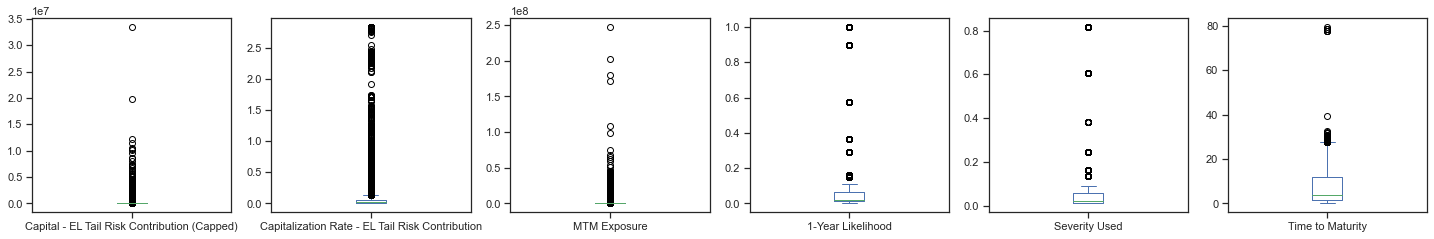

In [31]:
#Prior to rescaling...
df_dev[['Capital - EL Tail Risk Contribution (Capped)','Capitalization Rate - EL Tail Risk Contribution','MTM Exposure','1-Year Likelihood', 'Severity Used', 'Time to Maturity']].plot(kind='box', subplots=True, layout=(6,6), sharex=False, sharey=False,figsize=(25,25))
plt.show()

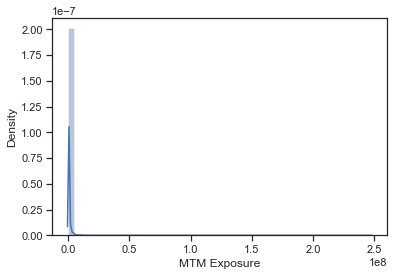

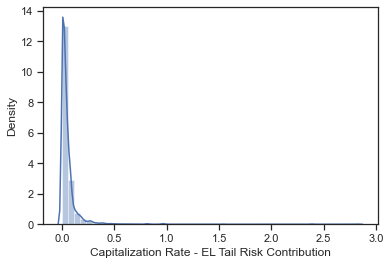

<Figure size 432x288 with 0 Axes>

In [32]:
#Prior to rescaling...
sns.distplot(df_dev['MTM Exposure'])
fig = plt.figure()

sns.distplot(df_dev['Capitalization Rate - EL Tail Risk Contribution'])
fig = plt.figure()

#### As we can see, the data is skewed to left. 
##### Let's get the square root values for the MTM Exposure and the Capital - EL Tail Risk Contribution (Capped) to get a better distribution.

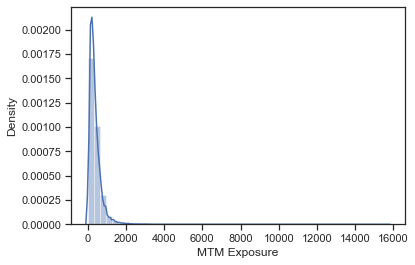

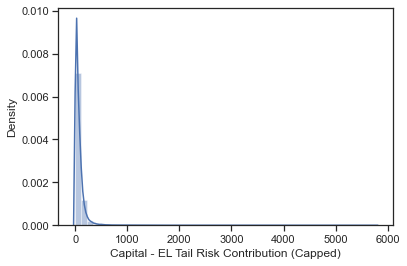

<Figure size 432x288 with 0 Axes>

In [33]:
temp1 = np.sqrt(df_dev['MTM Exposure'])
sns.distplot(temp1)
fig = plt.figure()

temp = np.sqrt(df_dev['Capital - EL Tail Risk Contribution (Capped)'])
sns.distplot(temp)
fig = plt.figure()

## Handling Outliers

#### Let's try the logarithmic values for the MTM Exposure and the Capital - EL Tail Risk Contribution (Capped) to get a better distribution.

In [34]:
df_dev.isnull().sum()

MTM Exposure                                       0
1-Year Likelihood                                  0
Severity Used                                      0
Industry Alias                                     0
Maturity Date                                      0
Time to Maturity                                   0
Capital - EL Tail Risk Contribution (Capped)       0
Capitalization Rate - EL Tail Risk Contribution    0
Asset Recovery Correlation                         0
Recovery R-Squared for Simulation                  0
Asset R-Squared for Simulation                     0
Instrument Type_Bond                               0
Instrument Type_Loan                               0
Instrument Subtype_Revolver                        0
dtype: int64

In [35]:
#use a masked array and NumPy will automatically apply a mask for the invalid values 
#df_dev['MTM Exposure_log'] = np.log((np.ma.array(df_dev['MTM Exposure'])))
#df_dev['Capital_log'] = np.log((np.ma.array(df_dev['Capital - EL Tail Risk Contribution (Capped)'])))
df_dev['MTM Exposure_log'] = np.log(df_dev['MTM Exposure'])
df_dev['Capital_log'] = np.log(df_dev['Capital - EL Tail Risk Contribution (Capped)'])

#### Applying log transformation introduced Null values into our dataset as a result of negative values present.

In [36]:
df_dev.isnull().sum()

MTM Exposure                                        0
1-Year Likelihood                                   0
Severity Used                                       0
Industry Alias                                      0
Maturity Date                                       0
Time to Maturity                                    0
Capital - EL Tail Risk Contribution (Capped)        0
Capitalization Rate - EL Tail Risk Contribution     0
Asset Recovery Correlation                          0
Recovery R-Squared for Simulation                   0
Asset R-Squared for Simulation                      0
Instrument Type_Bond                                0
Instrument Type_Loan                                0
Instrument Subtype_Revolver                         0
MTM Exposure_log                                    0
Capital_log                                        86
dtype: int64

#### We will drop those 86 rows containing null values:

In [37]:
df_dev.dropna(axis='rows', inplace = True)
df_dev

,MTM Exposure,1-Year Likelihood,Severity Used,Industry Alias,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,MTM Exposure_log,Capital_log
0,224013.330,0.160200,0.0570,1.0,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976,0,1,0,12.319461,10.964705
1,135000.000,0.036900,0.8170,1.0,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077,0,1,1,11.813030,10.058758
2,36190.953,0.036900,0.0190,2.0,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469,0,1,0,10.496564,7.351171
3,84600.000,0.006525,0.0190,1.0,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077,0,1,0,11.345690,6.556579
4,37508.787,0.020475,0.2470,1.0,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495,0,1,0,10.532331,8.189344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151527,260814.096,0.112725,0.0095,1.0,05/01/2040,18.751540,20564.36,0.078847,0.26706,0.34109,0.1347,0,1,0,12.471563,9.931315
151528,45000.000,0.006525,0.8170,1.0,05/01/2023,1.749487,4657.72,0.103505,0.26706,0.34109,0.1077,0,1,1,10.714418,8.446281
151529,182174.661,0.020700,0.0095,1.0,05/01/2030,8.750171,3428.36,0.018819,0.26706,0.34109,0.1235,0,1,0,12.112721,8.139837
151530,1179864.819,0.014400,0.0095,1.0,10/25/2039,18.234086,26063.25,0.022090,0.26706,0.34109,0.0769,0,1,0,13.980910,10.168282


#### The 'Capital_log' column contains 4026 rows that are <=0. We will drop these rows as it unlikely for actual values for Capital(USD) to be <=0. Also, we have a large dataset, such that dropping these rows will not impact the qaulity of our training data

In [38]:
df_dev = df_dev[df_dev['Capital_log'] >=0 ].reset_index(drop=True)
df_dev

,MTM Exposure,1-Year Likelihood,Severity Used,Industry Alias,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,MTM Exposure_log,Capital_log
0,224013.330,0.160200,0.0570,1.0,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976,0,1,0,12.319461,10.964705
1,135000.000,0.036900,0.8170,1.0,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077,0,1,1,11.813030,10.058758
2,36190.953,0.036900,0.0190,2.0,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469,0,1,0,10.496564,7.351171
3,84600.000,0.006525,0.0190,1.0,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077,0,1,0,11.345690,6.556579
4,37508.787,0.020475,0.2470,1.0,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495,0,1,0,10.532331,8.189344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147415,260814.096,0.112725,0.0095,1.0,05/01/2040,18.751540,20564.36,0.078847,0.26706,0.34109,0.1347,0,1,0,12.471563,9.931315
147416,45000.000,0.006525,0.8170,1.0,05/01/2023,1.749487,4657.72,0.103505,0.26706,0.34109,0.1077,0,1,1,10.714418,8.446281
147417,182174.661,0.020700,0.0095,1.0,05/01/2030,8.750171,3428.36,0.018819,0.26706,0.34109,0.1235,0,1,0,12.112721,8.139837
147418,1179864.819,0.014400,0.0095,1.0,10/25/2039,18.234086,26063.25,0.022090,0.26706,0.34109,0.0769,0,1,0,13.980910,10.168282


Text(0.5, 1.03, 'Capital ($) vs. other variables')

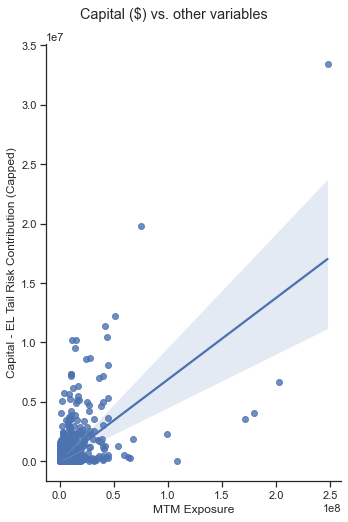

In [50]:
corr_pairs = sns.pairplot(df_dev, x_vars=['MTM Exposure'], 
                         y_vars='Capital - EL Tail Risk Contribution (Capped)', height=7, aspect=0.7, kind='reg')
corr_pairs.fig.suptitle('Capital ($) vs. other variables', y=1.03)

Text(0.5, 1.03, 'Capital ($) vs. other variables')

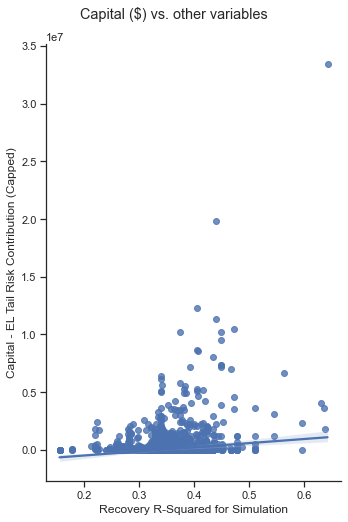

In [51]:
corr_pairs = sns.pairplot(df_dev, x_vars=['Recovery R-Squared for Simulation'], 
                         y_vars='Capital - EL Tail Risk Contribution (Capped)', height=7, aspect=0.7, kind='reg')
corr_pairs.fig.suptitle('Capital ($) vs. other variables', y=1.03)

Text(0.5, 1.03, 'Capital ($) vs. other variables')

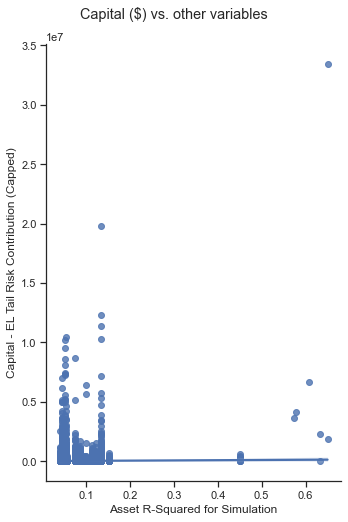

In [65]:
corr_pairs = sns.pairplot(df_dev, x_vars=['Asset R-Squared for Simulation'], 
                         y_vars='Capital - EL Tail Risk Contribution (Capped)', height=7, aspect=0.7, kind='reg')
corr_pairs.fig.suptitle('Capital ($) vs. other variables', y=1.03)

<AxesSubplot:xlabel='Asset R-Squared for Simulation', ylabel='Capital - EL Tail Risk Contribution (Capped)'>

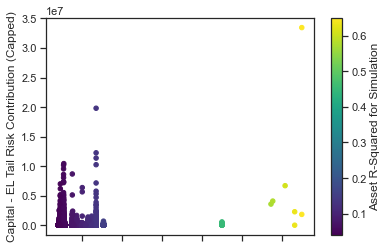

In [64]:
df_actuals.plot.scatter(x='Asset R-Squared for Simulation',
                      y='Capital - EL Tail Risk Contribution (Capped)',
                      c='Asset R-Squared for Simulation',
                       colormap='viridis')

<AxesSubplot:xlabel='Severity Used', ylabel='Capital - EL Tail Risk Contribution (Capped)'>

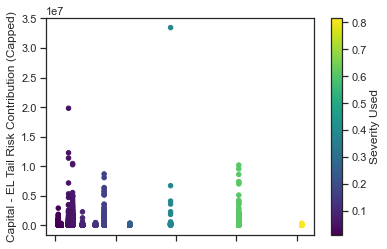

In [62]:
df_actuals.plot.scatter(x='Severity Used',
                      y='Capital - EL Tail Risk Contribution (Capped)',
                      c='Severity Used',
                       colormap='viridis')

In [39]:
#df_dev = df_dev.drop(df_actuals[df_actuals['Capital - EL Tail Risk Contribution (Capped)'] <=0].index)

In [40]:
df_dev.isnull().sum()

MTM Exposure                                       0
1-Year Likelihood                                  0
Severity Used                                      0
Industry Alias                                     0
Maturity Date                                      0
Time to Maturity                                   0
Capital - EL Tail Risk Contribution (Capped)       0
Capitalization Rate - EL Tail Risk Contribution    0
Asset Recovery Correlation                         0
Recovery R-Squared for Simulation                  0
Asset R-Squared for Simulation                     0
Instrument Type_Bond                               0
Instrument Type_Loan                               0
Instrument Subtype_Revolver                        0
MTM Exposure_log                                   0
Capital_log                                        0
dtype: int64

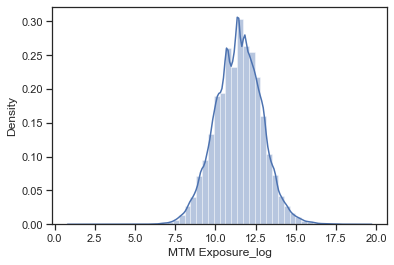

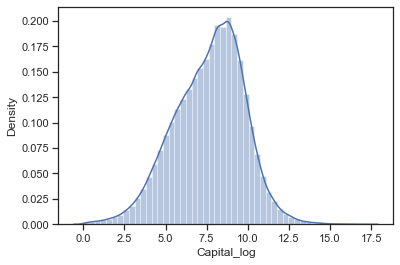

<Figure size 432x288 with 0 Axes>

In [41]:
# After to rescaling
sns.distplot(df_dev['MTM Exposure_log'])
fig = plt.figure()

sns.distplot(df_dev['Capital_log'])
fig = plt.figure()

#### getting the log values works better than the square root.

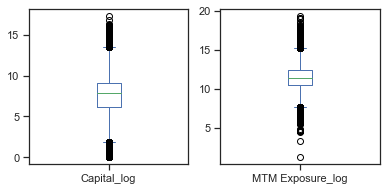

In [42]:
#After rescaling..
df_dev[['Capital_log','MTM Exposure_log']].plot(kind='box', subplots=True, layout=(6,6), sharex=False, sharey=False,figsize=(20,20))
plt.show()

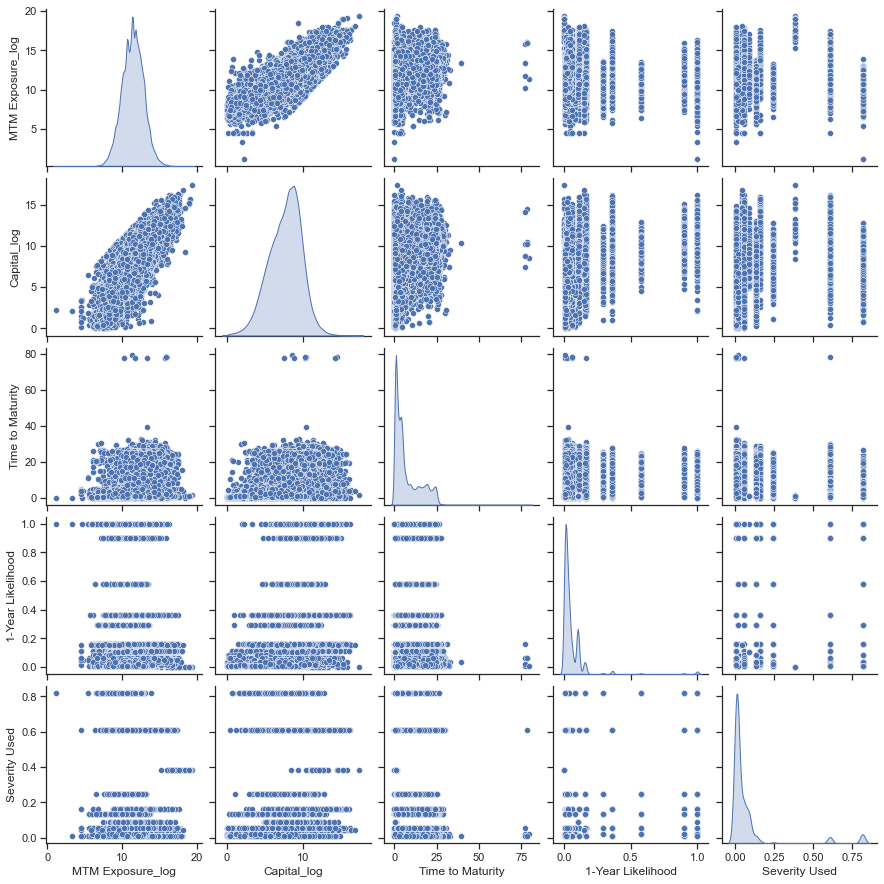

In [43]:
sns.pairplot(data=df_dev[['MTM Exposure_log','Capital_log', 'Time to Maturity', '1-Year Likelihood', 'Severity Used']], diag_kind='kde')

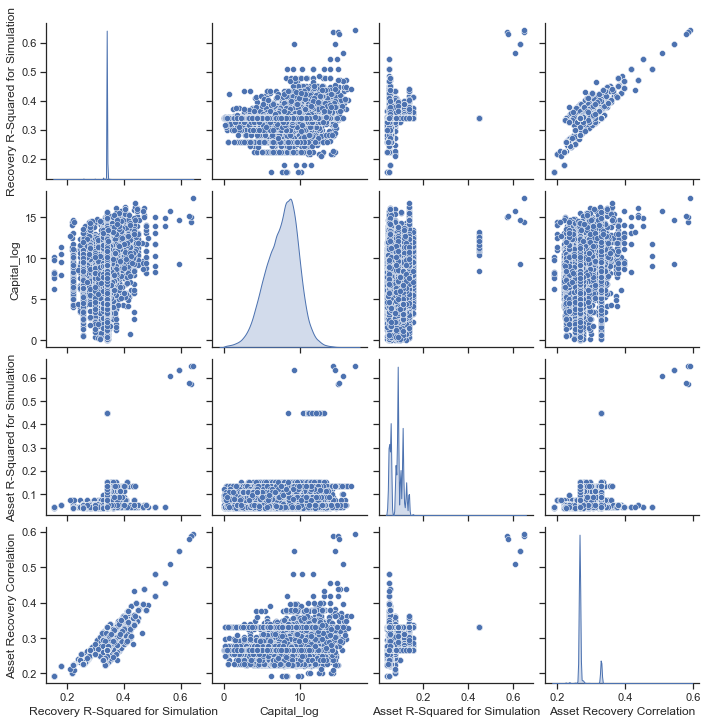

In [46]:
sns.pairplot(data=df_dev[['Recovery R-Squared for Simulation','Capital_log', 'Asset R-Squared for Simulation', 'Asset Recovery Correlation']], diag_kind='kde')

## Creating Linear Regression Models

In [45]:
df_dev

,MTM Exposure,1-Year Likelihood,Severity Used,Industry Alias,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,MTM Exposure_log,Capital_log
0,224013.330,0.160200,0.0570,1.0,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976,0,1,0,12.319461,10.964705
1,135000.000,0.036900,0.8170,1.0,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077,0,1,1,11.813030,10.058758
2,36190.953,0.036900,0.0190,2.0,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469,0,1,0,10.496564,7.351171
3,84600.000,0.006525,0.0190,1.0,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077,0,1,0,11.345690,6.556579
4,37508.787,0.020475,0.2470,1.0,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495,0,1,0,10.532331,8.189344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147415,260814.096,0.112725,0.0095,1.0,05/01/2040,18.751540,20564.36,0.078847,0.26706,0.34109,0.1347,0,1,0,12.471563,9.931315
147416,45000.000,0.006525,0.8170,1.0,05/01/2023,1.749487,4657.72,0.103505,0.26706,0.34109,0.1077,0,1,1,10.714418,8.446281
147417,182174.661,0.020700,0.0095,1.0,05/01/2030,8.750171,3428.36,0.018819,0.26706,0.34109,0.1235,0,1,0,12.112721,8.139837
147418,1179864.819,0.014400,0.0095,1.0,10/25/2039,18.234086,26063.25,0.022090,0.26706,0.34109,0.0769,0,1,0,13.980910,10.168282


#### Checking Correlation Matrix after rescaling

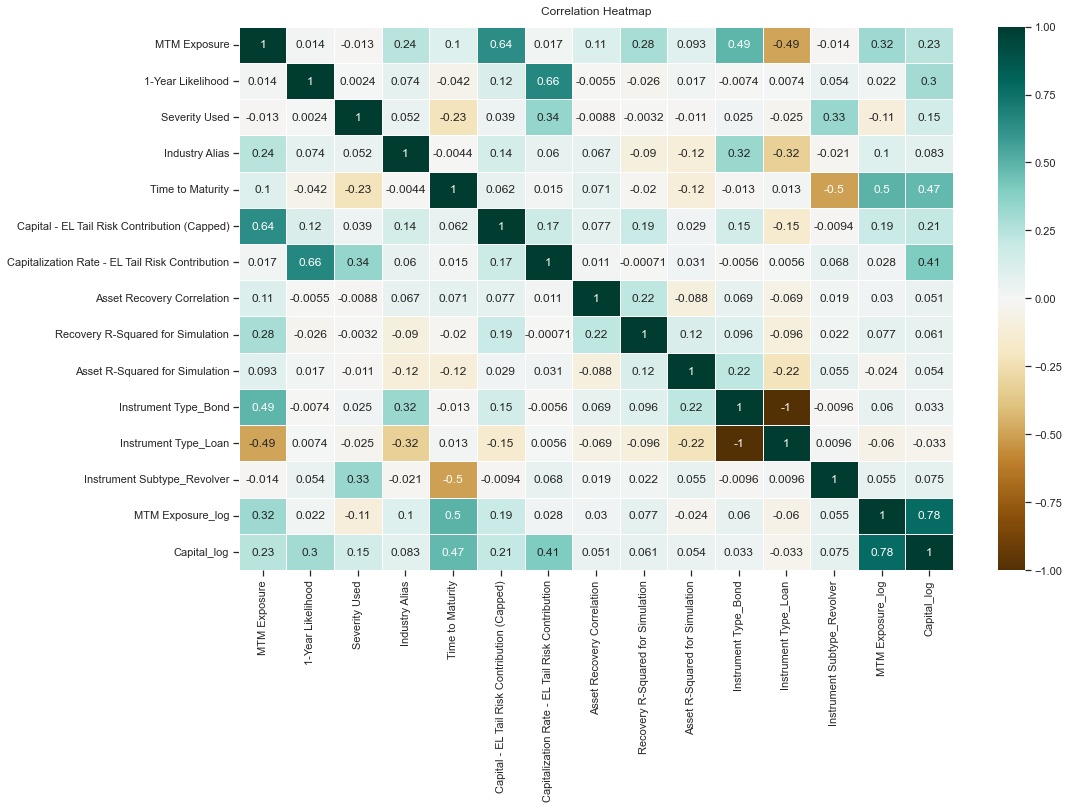

In [43]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_dev.corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG",linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [44]:
df_dev

,MTM Exposure,1-Year Likelihood,Severity Used,Industry Alias,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,Instrument Type_Bond,Instrument Type_Loan,Instrument Subtype_Revolver,MTM Exposure_log,Capital_log
0,224013.330,0.160200,0.0570,1.0,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976,0,1,0,12.319461,10.964705
1,135000.000,0.036900,0.8170,1.0,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077,0,1,1,11.813030,10.058758
2,36190.953,0.036900,0.0190,2.0,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469,0,1,0,10.496564,7.351171
3,84600.000,0.006525,0.0190,1.0,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077,0,1,0,11.345690,6.556579
4,37508.787,0.020475,0.2470,1.0,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495,0,1,0,10.532331,8.189344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147415,260814.096,0.112725,0.0095,1.0,05/01/2040,18.751540,20564.36,0.078847,0.26706,0.34109,0.1347,0,1,0,12.471563,9.931315
147416,45000.000,0.006525,0.8170,1.0,05/01/2023,1.749487,4657.72,0.103505,0.26706,0.34109,0.1077,0,1,1,10.714418,8.446281
147417,182174.661,0.020700,0.0095,1.0,05/01/2030,8.750171,3428.36,0.018819,0.26706,0.34109,0.1235,0,1,0,12.112721,8.139837
147418,1179864.819,0.014400,0.0095,1.0,10/25/2039,18.234086,26063.25,0.022090,0.26706,0.34109,0.0769,0,1,0,13.980910,10.168282


In [45]:
df_dev.describe().loc[['min','max', 'mean']].transpose()

,min,max,mean
MTM Exposure,3.309056,2.475000e+08,282660.226239
1-Year Likelihood,0.000225,1.000000e+00,0.055942
Severity Used,0.009500,8.170000e-01,0.078497
Industry Alias,1.000000,4.000000e+01,1.292742
Time to Maturity,0.002738,7.942779e+01,7.192983
Capital - EL Tail Risk Contribution (Capped),1.000000,3.345287e+07,16741.255505
Capitalization Rate - EL Tail Risk Contribution,0.000002,2.832520e+00,0.050560
Asset Recovery Correlation,0.192410,5.924700e-01,0.275663
Recovery R-Squared for Simulation,0.154790,6.425900e-01,0.340648
Asset R-Squared for Simulation,0.040000,6.500000e-01,0.082662


# Feature Selection and Scaling
 #### - Select independent variables as features.
 #### - Split the data set into train and test set with the first 70% of the data for training and the remaining 30% for testing.
 #### - Standardize numeric input variables by converting data to smaller values in the range 0 to 1 so that all of them lie on the    same scale and one doesn’t overpower the other. 

In [35]:
features = ['1-Year Likelihood', 'Severity Used', 'Time to Maturity','Asset Recovery Correlation', 'Recovery R-Squared for Simulation',
        'Asset R-Squared for Simulation', 'MTM Exposure_log']

X = df_dev[features]
y = df_dev['Capital_log']



#Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
display(X_train.head())
display(y_train)

,1-Year Likelihood,Severity Used,Time to Maturity,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,MTM Exposure_log
37205,0.020700,0.009500,1.174538,0.26706,0.34109,0.1235,11.813030
102702,0.020475,0.019000,5.919233,0.26706,0.34109,0.1077,11.715952
91917,0.045450,0.009500,3.956194,0.26706,0.34109,0.0860,11.227997
128199,0.102375,0.089775,0.621492,0.26706,0.34109,0.0976,11.967181
77157,0.008100,0.009500,2.373717,0.26706,0.34109,0.0549,10.544470


37205     6.551966
102702    7.384977
91917     6.955497
128199    9.737284
77157     4.937706
            ...   
119879    6.105418
103694    4.084463
131932    7.316754
146867    8.090693
121958    7.517238
Name: Capital_log, Length: 103194, dtype: float64

In [37]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(103194, 7) (103194,)
(44226, 7) (44226,)


# Training the Models

## Regression using a Deep Recurrent Neural Network(DRNN) and multiple inputs

This model will contain:

 - The normalization layer,
 - Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
 - A linear Dense single-output layer.

In [38]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

### Normalization

#### It is good practice to normalize features that use different scales and ranges.One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.Although a model might converge without feature normalization, normalization makes training much more stable.

#### The Normalization layer
The tf.keras.layers.experimental.preprocessing.Normalization is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [40]:
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)

#### Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [41]:
normalizer.adapt(np.array(X_train))

#### Calculate the mean and variance, and store them in the layer:

In [42]:
print(normalizer.mean.numpy())

[ 0.05604445  0.07803673  7.184995    0.27562216  0.34065238  0.0826245
 11.427983  ]


#### When the layer is called, it returns the input data, with each feature independently normalized:

In [43]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------

# root mean squared error (rmse) for regression
def rmse(y_pred, y_true):
    from tensorflow.keras import backend as K
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# coefficient of determination (R^2) for regression
def r_square(y_pred, y_true):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2


In [44]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      #norm,
      layers.Dense(64, activation='relu', input_shape =(X_train.shape[1],)),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])
 # rmse = tf.keras.metrics.RootMeanSquaredError(name='rmse')
    model.compile(loss='mean_squared_error',
                metrics=['mean_absolute_error',
                         rmse,
                         r_square],
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


#### Train the model with Keras Model.fit:

In [65]:
%%time
tf.autograph.set_verbosity(0)

history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2min 5s, sys: 20.8 s, total: 2min 25s
Wall time: 1min 41s


#### Visualize the model's training progress using the stats stored in the history object:

In [84]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.head())
display(hist.tail())

,loss,mean_absolute_error,rmse,r_square,val_loss,val_mean_absolute_error,val_rmse,val_r_square,epoch
0,0.323259,0.413287,0.559040,0.914598,0.331804,0.420093,0.566190,0.913659,0
1,0.322655,0.412529,0.558513,0.914730,0.352845,0.420957,0.582148,0.914271,1
2,0.321565,0.411803,0.557782,0.915277,0.350656,0.417687,0.580444,0.905035,2
3,0.323509,0.413800,0.559440,0.914803,0.333496,0.427249,0.567717,0.910042,3
4,0.322073,0.412602,0.558089,0.915147,0.344607,0.443739,0.578489,0.909414,4


,loss,mean_absolute_error,rmse,r_square,val_loss,val_mean_absolute_error,val_rmse,val_r_square,epoch
95,0.314827,0.405474,0.551852,0.917004,0.332308,0.427350,0.567687,0.912168,95
96,0.315821,0.406647,0.552949,0.916481,0.327100,0.412345,0.561574,0.914274,96
97,0.316379,0.407109,0.553313,0.916500,0.332426,0.430770,0.567700,0.911822,97
98,0.314832,0.405850,0.551471,0.917359,0.335021,0.438961,0.570202,0.906685,98
99,0.315497,0.406162,0.552035,0.917306,0.344631,0.406053,0.574627,0.906618,99


#### Plot the training curve for MSE:

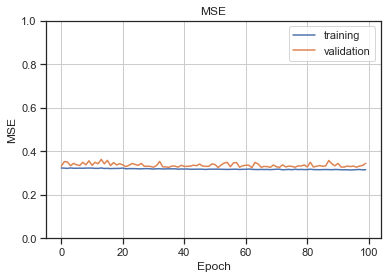

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0, 1])
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.legend()
plt.legend(['training', 'validation'], loc='upper right')
plt.grid(True)

#### Plot the training curve for RMSE:

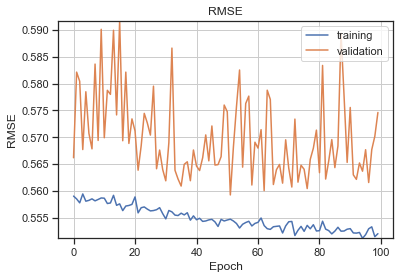

In [86]:
h_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']
plt.plot(h_rmse)
plt.plot(val_rmse)
p1 = min(min(h_rmse), min(val_rmse))
p2 = max(max(h_rmse), max(val_rmse))
plt.ylim([p1, p2])
plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
#plt.legend()
plt.legend(['training', 'validation'], loc='upper right')
plt.grid(True)

#### Plot the training curve for R^2 Score:

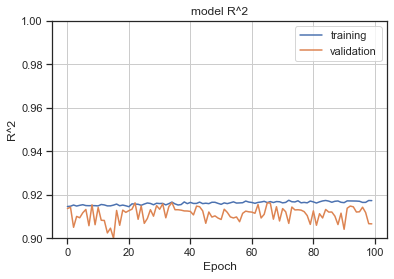

In [87]:
r2 = history.history['r_square']
val_r2 = history.history['val_r_square']
plt.plot(r2)
plt.plot(val_r2)
p1 = min(min(r2), min(val_r2))
p2 = max(max(r2), max(val_r2))
plt.ylim([min(val_r2), 1])
plt.title('model R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
#plt.legend()
plt.legend(['training', 'validation'], loc='upper right')
plt.grid(True)

#### Evaluate the result of the DRNN Model:

In [88]:
train_eval = dnn_model.evaluate(X_train, y_train, verbose=0)
print('Train MSE:      %.3f' % train_eval[0])
print('Train MAE:      %.3f' % train_eval[1])
print('Train RMSE:     %.3f' % train_eval[2])
print('Train R^2:      %.3f' % train_eval[3])

Train MSE:      0.329
Train MAE:      0.399
Train RMSE:     0.563
Train R^2:      0.911


In [89]:
test_eval = dnn_model.evaluate(X_test, y_test, verbose=0)

print('Test MSE:      %.3f' % test_eval[0])
print('Test MAE:      %.3f' % test_eval[1])
print('Test RMSE:     %.3f' % test_eval[2])
print('Test R^2:      %.3f' % test_eval[3])

Test MSE:      0.324
Test MAE:      0.395
Test RMSE:     0.558
Test R^2:      0.910


### Make predictions
#### We can now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss:

In [90]:
tf.autograph.set_verbosity(0)
y_pred = dnn_model.predict(X_test).flatten()
y_pred

array([8.40354  , 7.725079 , 4.585647 , ..., 5.804219 , 3.3616517,
       4.2857547], dtype=float32)

#### Plot a graph to display the datapoints:

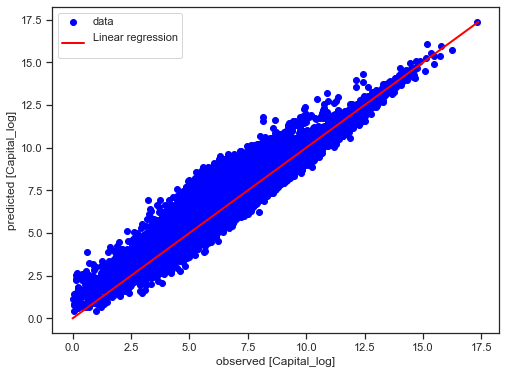



Mean squared error (MSE):         0.324
Mean absolute error (MAE):        0.395
Root mean squared error (RMSE):   0.569
R square (R^2):                   0.927


In [91]:
from tensorflow.keras import backend as K
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', label= 'data')
plt.xlabel('observed [Capital_log]')
plt.ylabel('predicted [Capital_log]')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
lims = [p2, p1]
plt.plot(lims, lims,color='red', linewidth=2, label = 'Linear regression\n')
plt.legend()
plt.show()

#-----------------------------------------------------------------------------
#              print statistical figures
#-----------------------------------------------------------------------------
print("\n")
print("Mean squared error (MSE):         %.3f" % mean_squared_error(y_test,y_pred))
print("Mean absolute error (MAE):        %.3f" % mean_absolute_error(y_test,y_pred))
print("Root mean squared error (RMSE):   %.3f" % np.sqrt(mean_squared_error(y_test,y_pred)))
print("R square (R^2):                   %.3f" % r2_score(y_test,y_pred))


#### It appears that the model predicts reasonably well.

#### Let us check the error distribution: 

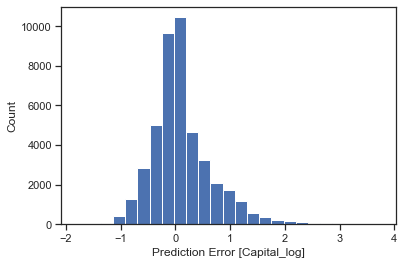

In [92]:
error = y_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Capital_log]')
_ = plt.ylabel('Count')

###  Reverse the Log-transformed features and target variable after training
#### r2 score interpretation

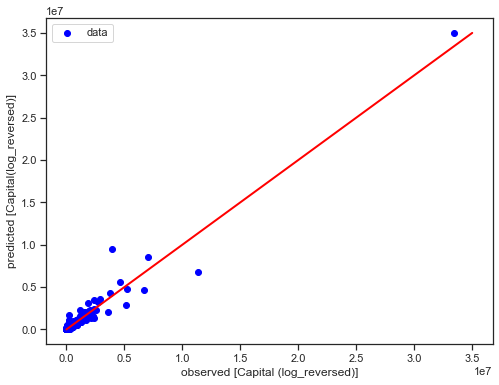



REVERSED Mean squared error (MSE):         2024410021.95
REVERSED absolute error (MAE):             3642.57
REVERSED Rootmean squared error (RMSE):    44993.44
REVERSED R square (R^2):                   0.95


In [93]:
inverse_y_test = np.exp(y_test)
inverse_y_pred = np.exp(y_pred)

plt.figure(figsize=(8,6))
plt.scatter(inverse_y_test, inverse_y_pred, color='blue', label= 'data')
plt.xlabel('observed [Capital (log_reversed)]')
plt.ylabel('predicted [Capital(log_reversed)]')
p1 = max(max(inverse_y_pred), max(inverse_y_test))
p2 = min(min(inverse_y_pred), min(inverse_y_test))
lims = [p2, p1]
plt.plot(lims, lims,color='red', linewidth=2) #, label = 'Linear regression\n'
plt.legend()
plt.show()

#-----------------------------------------------------------------------------
#              print statistical figures
#-----------------------------------------------------------------------------
print("\n")
print("REVERSED Mean squared error (MSE):         %.2f" % mean_squared_error(inverse_y_test,inverse_y_pred))
print("REVERSED absolute error (MAE):             %.2f" % mean_absolute_error(inverse_y_test,inverse_y_pred))
print("REVERSED Rootmean squared error (RMSE):    %.2f" % np.sqrt(mean_squared_error(inverse_y_test,inverse_y_pred)))
print("REVERSED R square (R^2):                   %.2f" % r2_score(inverse_y_test,inverse_y_pred))

In [94]:
df_nn_inverse = pd.DataFrame({'Target_Y':inverse_y_test, 'Predicted_Y': inverse_y_pred})
df_nn_inverse

,Target_Y,Predicted_Y
138596,4761.46,4462.835938
63126,2268.36,2264.431641
90809,21.13,98.066628
109923,3598.57,3986.460205
88752,55.04,56.227585
...,...,...
16546,1384.20,705.172607
49759,2238.68,2148.800537
139682,392.85,331.695953
111331,62.38,28.836781


#### It appears that the model predicts reasonably well.

## Hold-Out Testing

In [95]:
h_out = pd.read_csv('Holdout Test - Actuals Removed.csv')
h_out.head()

,Instrument,Instrument Type,Instrument Subtype,Counterparty Alias,MTM Exposure,Book Exposure,1-Year Likelihood,Severity Used,Industry Alias,Commitment,Country of Incorporation,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation
0,49146,Loan,Term Loan Amortizing,C13207,89465.73891,89518.73,0.006525,0.1330,IND1,89518.73,CAN,02/16/2037,15.548255,NaN,NaN,0.33000,0.34000,0.0484
1,62941,Loan,Term Loan Amortizing,C34003,42068.35800,42068.35,0.033975,0.0095,IND1,42068.35,CAN,11/25/2026,5.319644,NaN,NaN,0.26706,0.34109,0.0549
2,87386,Loan,Term Loan Amortizing,C93,31293.97200,31293.97,0.006525,0.0190,IND1,31293.97,CAN,04/01/2024,2.669405,NaN,NaN,0.26706,0.34109,0.1077
3,148592,Loan,Term Loan Amortizing,C51685,810000.00000,810000.00,0.014400,0.6080,IND5,810000.00,CAN,01/02/2032,10.422998,NaN,NaN,0.25273,0.34550,0.0532
4,84761,Loan,Term Loan Amortizing,C49430,256009.86000,256009.86,0.062550,0.0570,IND1,256009.86,CAN,10/01/2038,17.169062,NaN,NaN,0.26706,0.34109,0.0549


### Process Data
We will perform the same preprocessing we did on the development dataset on the holdout data.

In [96]:
df_holdout = h_out.copy()
df_holdout = df_holdout.drop(['Instrument', 'Counterparty Alias', 'Industry Alias', 'Commitment','Book Exposure', 'Country of Incorporation', 'Maturity Date','Capital - EL Tail Risk Contribution (Capped)','Capitalization Rate - EL Tail Risk Contribution'], axis=1)

#get dummy columns
df0_dummies = pd.get_dummies(df_holdout[['Instrument Type', 'Instrument Subtype']])
#join the new columns with your original dataframe
df_holdout = pd.concat([df_holdout,df0_dummies],axis=1)

df_holdout['MTM Exposure_log'] = np.log(df_holdout['MTM Exposure'])

# drop the columns you don't need it
df_holdout.drop(['Instrument Type', 'Instrument Subtype', 'Instrument Type_Bond','Instrument Type_Loan','Instrument Subtype_Term Loan Amortizing', 'Instrument Subtype_Revolver'],axis=1, inplace=True)
df_holdout

,MTM Exposure,1-Year Likelihood,Severity Used,Time to Maturity,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,MTM Exposure_log
0,89465.73891,0.006525,0.133000,15.548255,0.33000,0.34000,0.0484,11.401611
1,42068.35800,0.033975,0.009500,5.319644,0.26706,0.34109,0.0549,10.647051
2,31293.97200,0.006525,0.019000,2.669405,0.26706,0.34109,0.1077,10.351181
3,810000.00000,0.014400,0.608000,10.422998,0.25273,0.34550,0.0532,13.604790
4,256009.86000,0.062550,0.057000,17.169062,0.26706,0.34109,0.0549,12.452971
...,...,...,...,...,...,...,...,...
14995,129144.70800,0.036900,0.019000,14.422998,0.33000,0.34000,0.0469,11.768689
14996,90000.00000,0.102375,0.089775,0.621492,0.26706,0.34109,0.0860,11.407565
14997,6046.52400,0.020700,0.009500,2.086242,0.26706,0.34109,0.0549,8.707239
14998,156508.74000,0.020700,0.009500,6.836413,0.26706,0.34109,0.0860,11.960867


In [97]:
df_holdout = df_holdout[df_holdout['MTM Exposure_log'] >=0 ].reset_index(drop=True)
df_temp = df_holdout.copy() # just so we can get some of the original values back after predicting...
df_holdout.drop(['MTM Exposure'], axis =1, inplace=True)
df_holdout

,1-Year Likelihood,Severity Used,Time to Maturity,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,MTM Exposure_log
0,0.006525,0.133000,15.548255,0.33000,0.34000,0.0484,11.401611
1,0.033975,0.009500,5.319644,0.26706,0.34109,0.0549,10.647051
2,0.006525,0.019000,2.669405,0.26706,0.34109,0.1077,10.351181
3,0.014400,0.608000,10.422998,0.25273,0.34550,0.0532,13.604790
4,0.062550,0.057000,17.169062,0.26706,0.34109,0.0549,12.452971
...,...,...,...,...,...,...,...
14626,0.036900,0.019000,14.422998,0.33000,0.34000,0.0469,11.768689
14627,0.102375,0.089775,0.621492,0.26706,0.34109,0.0860,11.407565
14628,0.020700,0.009500,2.086242,0.26706,0.34109,0.0549,8.707239
14629,0.020700,0.009500,6.836413,0.26706,0.34109,0.0860,11.960867


In [98]:
tf.autograph.set_verbosity(0)
ho_pred = dnn_model.predict(df_holdout).flatten()

df_hold_dnn = df_holdout.copy()

df_hold_dnn['Capital - EL Tail Risk Contribution (Capped)_log_PREDICTED'] = ho_pred.round(3)
#calculate the Capitalization Rate from the predicted Capital ($)
df_hold_dnn['Capitalization Rate - EL Tail Risk Contribution_log_PREDICTED'] = df_hold_dnn.apply(lambda row: row['Capital - EL Tail Risk Contribution (Capped)_log_PREDICTED'] / row['MTM Exposure_log'], axis=1).round(3)

#Reverse the Log-transformed features and target variables and add to them as new columns
df_hold_dnn['MTM Exposure_INVERSED'] = df_temp['MTM Exposure'].round(3)
df_hold_dnn['Capital - EL Tail Risk Contribution (Capped)_PREDICTED_INVERSED'] = np.exp(df_hold_dnn['Capital - EL Tail Risk Contribution (Capped)_log_PREDICTED'] ).round(3)
df_hold_dnn['Capitalization Rate - EL Tail Risk Contribution_PREDICTED_INVERSED'] = np.exp(df_hold_dnn['Capitalization Rate - EL Tail Risk Contribution_log_PREDICTED'] ).round(3)

df_hold_dnn.to_csv('Neural_Network_Holdout.csv', index=False)
display(df_hold_dnn)


,1-Year Likelihood,Severity Used,Time to Maturity,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation,MTM Exposure_log,Capital - EL Tail Risk Contribution (Capped)_log_PREDICTED,Capitalization Rate - EL Tail Risk Contribution_log_PREDICTED,MTM Exposure_INVERSED,Capital - EL Tail Risk Contribution (Capped)_PREDICTED_INVERSED,Capitalization Rate - EL Tail Risk Contribution_PREDICTED_INVERSED
0,0.006525,0.133000,15.548255,0.33000,0.34000,0.0484,11.401611,8.300,0.728,89465.739,4023.873047,2.071
1,0.033975,0.009500,5.319644,0.26706,0.34109,0.0549,10.647051,6.284,0.590,42068.358,535.927979,1.804
2,0.006525,0.019000,2.669405,0.26706,0.34109,0.1077,10.351181,5.255,0.508,31293.972,191.522003,1.662
3,0.014400,0.608000,10.422998,0.25273,0.34550,0.0532,13.604790,11.857,0.872,810000.000,141068.421875,2.392
4,0.062550,0.057000,17.169062,0.26706,0.34109,0.0549,12.452971,10.122,0.813,256009.860,24884.484375,2.255
...,...,...,...,...,...,...,...,...,...,...,...,...
14626,0.036900,0.019000,14.422998,0.33000,0.34000,0.0469,11.768689,8.450,0.718,129144.708,4675.071777,2.050
14627,0.102375,0.089775,0.621492,0.26706,0.34109,0.0860,11.407565,8.788,0.770,90000.000,6555.109863,2.160
14628,0.020700,0.009500,2.086242,0.26706,0.34109,0.0549,8.707239,3.320,0.381,6046.524,27.660000,1.464
14629,0.020700,0.009500,6.836413,0.26706,0.34109,0.0860,11.960867,7.843,0.656,156508.740,2547.836914,1.927


### Save Model
We will save our DNN Model for later use:

In [99]:
dnn_model.save('dnn_saved_model')

### Reload Model
We will reload out model and check out prediction to sure it works.

In [100]:
reloaded = tf.keras.models.load_model('dnn_saved_model',custom_objects={'rmse':rmse,'r_square':r_square})
reloaded

### Check Model Accuracy
We will now check our reloaded model's accuracy:

In [101]:
y_check = reloaded.predict(X_test).flatten()
print("R square (R^2):                   %.3f" % r2_score(y_test,y_check))

R square (R^2):                   0.927


#### We got the same prediction as before (same seed)!

# Observation and Conclusion

#### - We found that our dataset contained 3 features <i>(MTM Exposure, Commitment and Book Exposure)</i> that were HIGHLY correlated with each other and with the target variable <i>(Capital - EL Tail Risk Contribution (Capped))</i>, we therefore dropped 2 of them and kept only MTM Exposure. All the other features had very low (or negative) coefficiencies in relation to our target. 

#### - Transforming the main predictor and the target variable prior to training (Normalization), using Log Transformation rescaled the data to have a semblance of standard normal distribution. This helped our model learn better and quicker.

#### - Adding feature normalization to our model using the TF Keras Normalizer Layer forced all the inputs into a distribution centered around 0 with standard deviation 1(Standardization). This provided better rescaling than the Scikit-learn's PowerTransformer scaler that we used for our prior models <i>(Linear Regression, Decision Tree and Random Forest)</i>.

#### - Overall, the DNN model performed better that the <i>(Linear Regression, Decision Tree and Random Forest)</i>. It exhibitted less overfitting/underfitting and produced consistent results on both the Development and Hold-out datasets.

*** 

## <p style="text-align: center;"> END </p>